In [1]:
# need protobuf 3.6.1 on ubuntu 20.04 otherwise we get some errors when installing gcld3
!conda install -y protobuf=3.6.1 gdown
!apt update -y && apt install -y libprotobuf-dev
!pip install gcld3 language_data

Solving environment: / failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import to_rgb
import seaborn as sns
import os
import gc
import glob
import urllib
import gdown
import multiprocessing
from langcodes import tag_is_valid, Language

import fasttext
import gcld3

from wordcloud import WordCloud
import spacy

from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

sns.set_theme()


# Disclaimer
To process everything you'll need way more than 12 hours (max duration of notebook session). We download the cached results so that this notebook runs in reasonable time. To compute everything from scratch, change `running_from_scratch` to `true` and run the notebook multiple times. Each time it will write results to disk and build upon those results. Make sure file persistence is on.

In [3]:
running_from_scratch = False
if not running_from_scratch:
    # download intermediate results so that we don't wait 40h
    print("Downloadin intermediate results...")
    ids = ["1uwEvFCkTfV-pZcSKBPLEvgDM7M8QkhKq", "1MscGmpAfFVKGbRAmuww5ZOFHN8bDhh60", "1i_wblpbtLP_iX8dv4EDVnQG8clSpaRpE"]
    for id_ in ids:
        gdown.download(f"https://drive.google.com/uc?id={id_}")

Downloadin intermediate results...


Downloading...
From: https://drive.google.com/uc?id=1uwEvFCkTfV-pZcSKBPLEvgDM7M8QkhKq
To: /kaggle/working/df_eng.zip
100%|██████████| 1.85G/1.85G [00:23<00:00, 77.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MscGmpAfFVKGbRAmuww5ZOFHN8bDhh60
To: /kaggle/working/ds2_processed.zip
100%|██████████| 3.11G/3.11G [00:43<00:00, 71.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1i_wblpbtLP_iX8dv4EDVnQG8clSpaRpE
To: /kaggle/working/vectors.npy
100%|██████████| 8.10G/8.10G [01:33<00:00, 86.6MB/s]


In [4]:
# download language model
print("Downloading language model...")
url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
urllib.request.urlretrieve(url, f"/kaggle/working/{url.split('/')[-1]}")

('/kaggle/working/lid.176.bin', <http.client.HTTPMessage at 0x7f6fb504c490>)

# Overview

In [5]:
if not running_from_scratch:
    # If you plan on processing everything from scratch, don't bother running this exploratory cell, it'll just eat up memory
    def explore_df(path, cols, dtypes):
        # Loading data. The dataset is big, so we only load the columns that may be interesting
        df = pd.read_csv(path, usecols=cols, dtype=dtypes)
        print(df.info())
        print(f"Unique tags (genres): {df['tag'].unique()}")
    
    # use a thread pool of 1 thread (lol) because python is incapable of freeing memory
    with multiprocessing.Pool(1) as pool:
        pool.starmap(explore_df, [(
            "/kaggle/input/5-million-song-lyrics-dataset/ds2.csv",
            ["title", "artist", "year", "tag", "views", "lyrics"],
            {"year": np.int16, "views": np.int32})
        ])
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913411 entries, 0 to 5913410
Data columns (total 6 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   title   object
 1   tag     object
 2   artist  object
 3   year    int16 
 4   views   int32 
 5   lyrics  object
dtypes: int16(1), int32(1), object(4)
memory usage: 214.3+ MB
None
Unique tags (genres): ['rap' 'rb' 'rock' 'pop' 'misc' 'country']


# Preprocessing
The data is big. We'll have to process it in batches, save to disk, then combine the batches

Lyrics information is not classified by language. We'll do that by combining the result of two models: gcld3 and fasttext.

In [6]:
if running_from_scratch:
    # We only need the language models if we are running from scratch
    gcld3_model = gcld3.NNetLanguageIdentifier(min_num_bytes=10, max_num_bytes=1000)
    fasttext_model = fasttext.load_model("/kaggle/working/lid.176.bin")

    def sanitize_lang_token(token):
        if not tag_is_valid(token):
            print(f"Found unknown language token: {token}")
            return np.nan
        else:
            # "fil" -> Filipino -> "fil"
            # "tl" -> Filipino -> "fil"
            lang_natural_name = Language.get(token).display_name("en")
            return str(Language.find(lang_natural_name, "en"))

    def identify_language(text, method):
        if method == "cld3":
            res = gcld3_model.FindLanguage(text=text)
            return sanitize_lang_token(res.language) if res.is_reliable else np.nan
        elif method == "ft":
            res = fasttext_model.predict(text)
            return (
                sanitize_lang_token(res[0][0][len("__label__"):])
                if res[1][0] >= 0.5
                else np.nan
            )

## Cleaning records and labeling songs by language

In [7]:
if not os.path.isfile("/kaggle/working/ds2_processed.csv") and not os.path.isfile("/kaggle/working/ds2_processed.zip"):
    # Read file in chunks
    with pd.read_csv(
            "/kaggle/input/5-million-song-lyrics-dataset/ds2.csv",
            chunksize=5 * 10**5,
            usecols=["title", "artist", "year", "tag", "views", "lyrics"],
            dtype={"year": np.int16, "views": np.int32}
        ) as chunks:

            for idx, chunk in enumerate(chunks):
                print(f"Processing chunk {idx}")

                # drop N.A. lyrics
                chunk = chunk.dropna(subset=["lyrics"])
                # drop romanizations
                chunk = chunk[chunk["artist"] != "Genius Romanizations"]
                chunk = chunk[
                    ~chunk["title"].str.contains(
                        r"\(?romanized\)?", regex=True, na=False, case=False
                    )
                ]

                # drop values that make no sense (the data was collected in 2022)
                chunk = chunk[chunk["year"] < 2023]
                # remove duplicated entries
                chunk = chunk.drop_duplicates(subset=["title", "artist", "year"])

                # Clean lyrics a bit (remove [Chorus], [Produced], [Intro])
                pattern = r"(?m)^\[.*?\]$"
                chunk["lyrics"] = chunk["lyrics"].str.replace(pattern, "", regex=True)
                pattern = r"\n|\n\n"
                chunk["lyrics"] = chunk["lyrics"].str.replace(pattern, " ", regex=True)

                # drop songs that are too small or too big
                # normally too small are complete nonsense and too big are entire books (which are allowed on Genius btw)
                chunk = chunk[chunk["lyrics"].str.len().between(10**2, 10**5)]

                chunk["language_cld3"] = chunk["lyrics"].apply(
                    identify_language, args=("cld3",)
                )
                print(
                    f'{len(chunk[chunk["language_cld3"].isna()])} not identified lyrics using cld3'
                )
                chunk["language_ft"] = chunk["lyrics"].apply(
                    identify_language, args=("ft",)
                )
                print(
                    f'{len(chunk[chunk["language_ft"].isna()])} not identified lyrics using fasttext'
                )

                # Logic to combine the results of the two language model
                # We only combine if them both agree
                def combine_func(token_ft, token_cld3):
                    if pd.notna(token_ft) and pd.notna(token_cld3):
                        return token_ft if token_ft == token_cld3 else np.nan

                    return np.nan

                chunk["language"] = chunk["language_ft"].combine(
                    chunk["language_cld3"], combine_func, fill_value=np.nan
                )

                chunk.to_csv("/kaggle/working/ds2_processed.csv", mode="a", header=not os.path.exists("/kaggle/working/ds2_processed.csv"), index=False)

    del chunk
    gc.collect()

In [8]:
# Save some disk space
!zip ds2_processed.zip ds2_processed.csv
!rm "/kaggle/working/ds2_processed.csv"


zip error: Nothing to do! (ds2_processed.zip)
rm: cannot remove '/kaggle/working/ds2_processed.csv': No such file or directory


# Visualizations

In [9]:
def create_visualizations(processed_df_path, dtypes, compression):
    df = pd.read_csv(processed_df_path, dtype={"year": np.int16, "views": np.int32}, compression=compression)
    
    # Visualization for views, years, tags and song lengths
    fig, axes = plt.subplots(2, 2, figsize=(18, 12), dpi=100)
    ax1, ax2, ax3, ax4 = axes.flatten()

    # Views distribution
    views_categories = pd.cut(df["views"], bins=[0, 100, 500, 1000, 10 ** 4, 10 ** 5, 10 ** 6, 10 ** 9], include_lowest=True, right=False)
    views_categories = views_categories.sort_values().astype(str)
    views_bins = views_categories.unique()

    sns.histplot(views_categories, ax=ax1)
    ax1.set_title("By views", fontsize=20)
    ax1.xaxis.set_ticks(views_bins)
    ax1.set_xticklabels(["[0-100)", "[100-500)", "[500-1k)", "[1k-10k)", "[10k-100k)", "[100k-1m)", "[1m-1b)"])
    for patch, color in zip(ax1.patches, sns.color_palette("coolwarm", n_colors=len(views_bins)).as_hex()):
        patch.set_facecolor((*to_rgb(color), 0.5))

    # Years distribution
    years_categories = pd.cut(df.loc[df["year"].notna(), "year"], bins=[0, 1900, 1925, 1950, 1975, 2000, 2023], include_lowest=True, right=False)
    years_categories = years_categories.sort_values().astype(str)
    years_bins = years_categories.unique()

    sns.histplot(years_categories, ax=ax2)
    ax2.set_title("By year", fontsize=20)
    ax2.xaxis.set_ticks(years_bins)
    ax2.set_xticklabels(["[0-1900)", "[1900-1925)", "[1925-1950)", "[1950-1975)", "[1975-2000)", "[2000-2023)"])
    for patch, color in zip(ax2.patches, sns.color_palette("cubehelix", n_colors=len(years_bins)).as_hex()):
        patch.set_facecolor((*to_rgb(color), 0.5))

    # Tags distribution
    sns.histplot(x="tag", hue="tag", data=df, ax=ax3)
    ax3.set_title("By tag", fontsize=20)
    
    # Song length distribution
    sns.histplot(df["lyrics"].str.len(), stat="percent", log_scale=(True, False), bins=20, ax=ax4)
    ax4.set_title("By song length", fontsize=20)
    
    fig.suptitle("Song distribution", fontsize=30)
    fig.tight_layout()
    plt.savefig("song_distributions.png")
    plt.close(fig)
    
    # Visualization for song popularity by language
    df["language_name"] = df["language"].apply(lambda x: Language.get(x).display_name('en') if pd.notna(x) else np.nan)
    lang_df = df.groupby("language_name")["views"].agg([pd.Series.mean, pd.Series.count]).reset_index()

    # Plot mean song popularity by language
    fig, ax = plt.subplots(figsize=(18, 10))
    sns.scatterplot(data=lang_df, x="mean", y="count", hue="language_name", legend=False, s=50, ax=ax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title("Song count and popularity by language", fontsize=30)
    ax.set_xlabel("Mean number of views", fontsize=20)
    ax.set_ylabel("Number of songs", fontsize=20)

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    
    # Add language name to each dot in the scatterplot
    for idx, row in lang_df.iterrows():
        ax.text(row["mean"], row["count"], row["language_name"], horizontalalignment="left", size="medium", color="black", weight="semibold")
    fig.tight_layout()
    plt.savefig("song_popularity_by_language.png")
    plt.close(fig)

In [10]:
with multiprocessing.Pool(1) as pool:
    pool.starmap(create_visualizations, [(
        "/kaggle/working/ds2_processed.zip",
        {"year": np.int16, "views": np.int32},
        "zip")
    ])

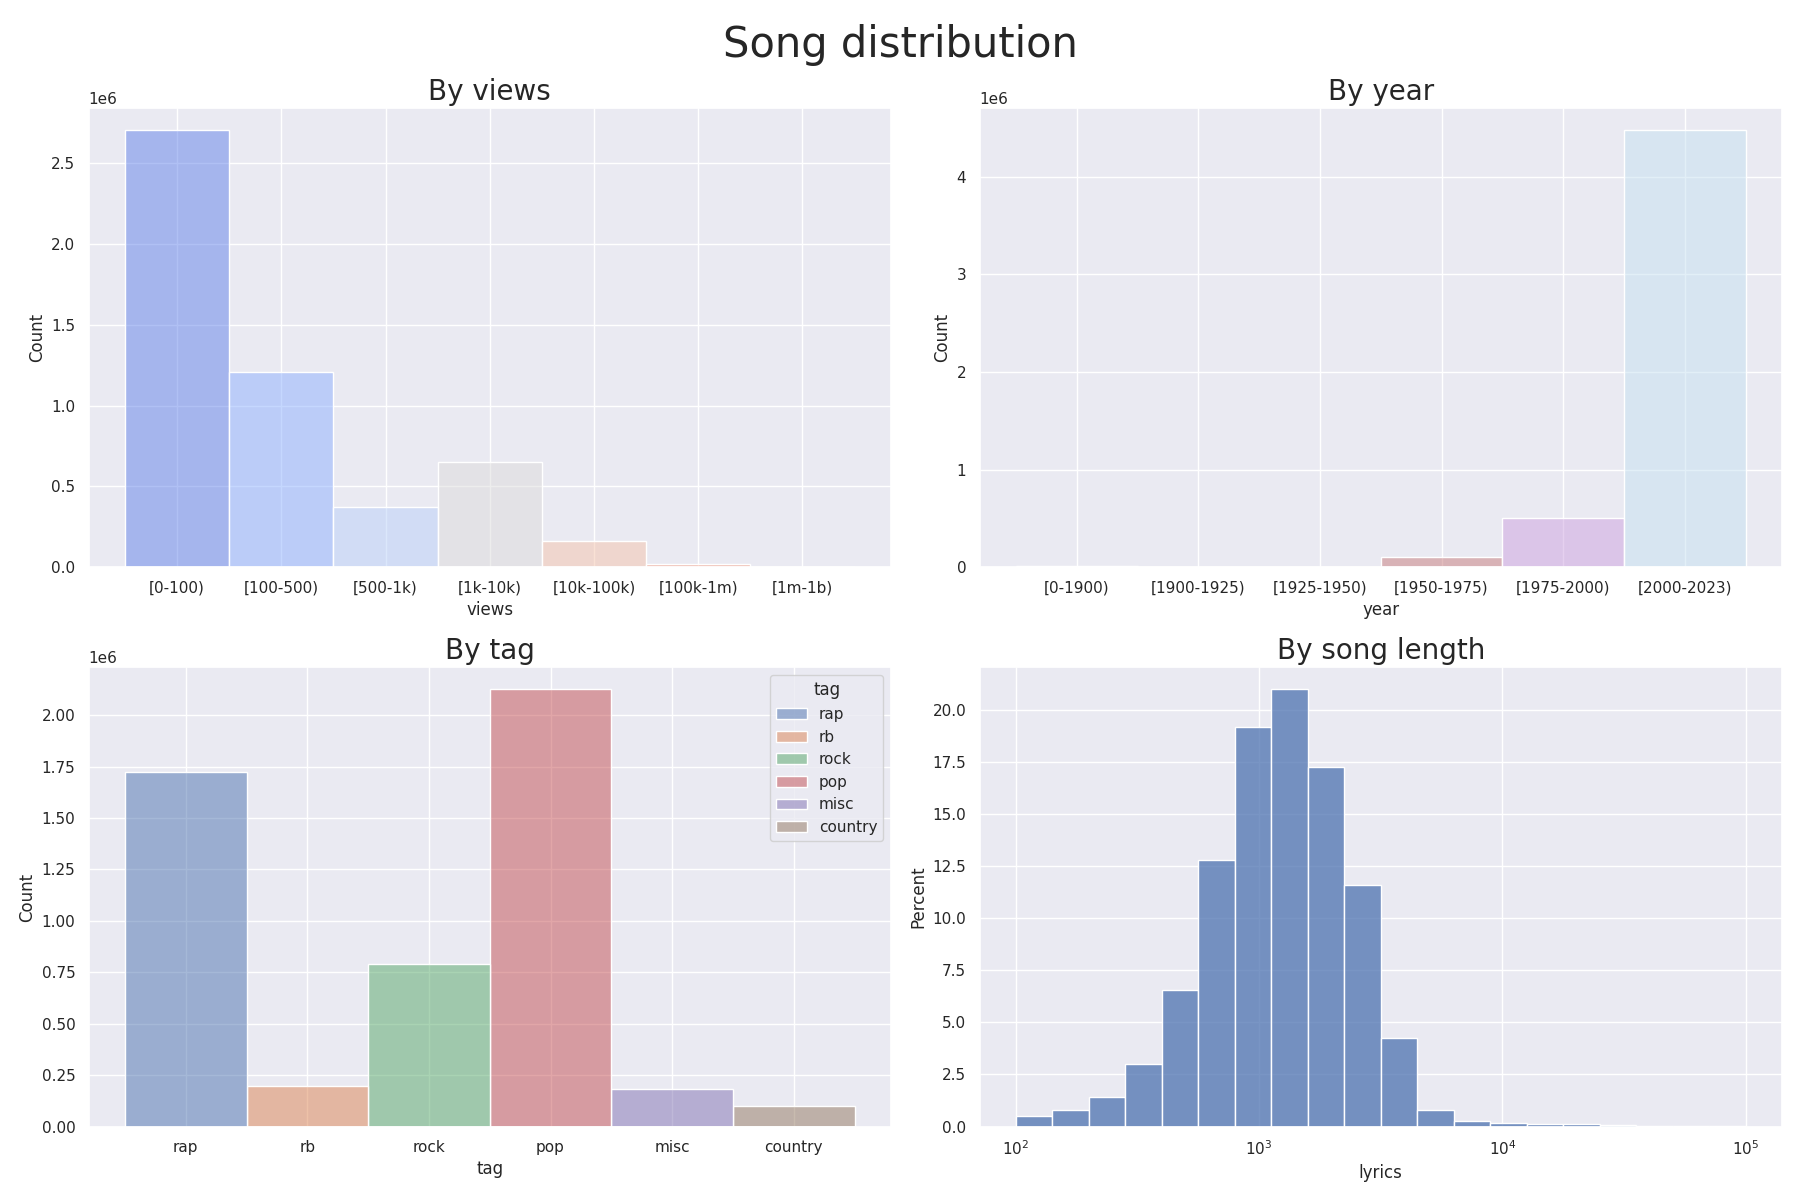

In [11]:
from IPython.display import Image
Image("song_distributions.png")

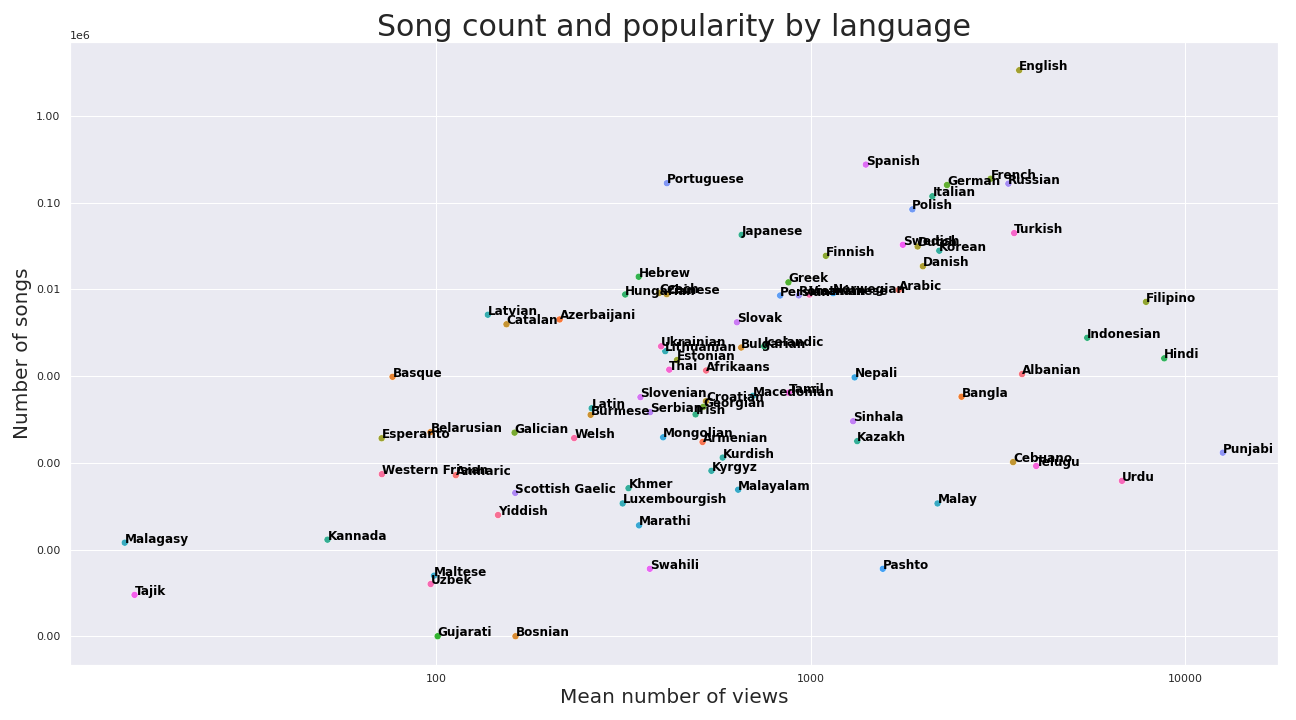

In [12]:
Image("song_popularity_by_language.png")

# Analyzing english songs

In [13]:
if not os.path.isfile("/kaggle/working/df_eng.zip"):
    df = df[df["language"] == "en"]
    df = df.drop(columns=["language", "language_ft", "language_cld3", "language_name"])
    df.to_csv("df_eng.zip", compression=dict(method="zip", archive_name="df_eng.csv"))
else:
    df = pd.read_csv("df_eng.zip", dtype={"year": np.int16, "views": np.int32})

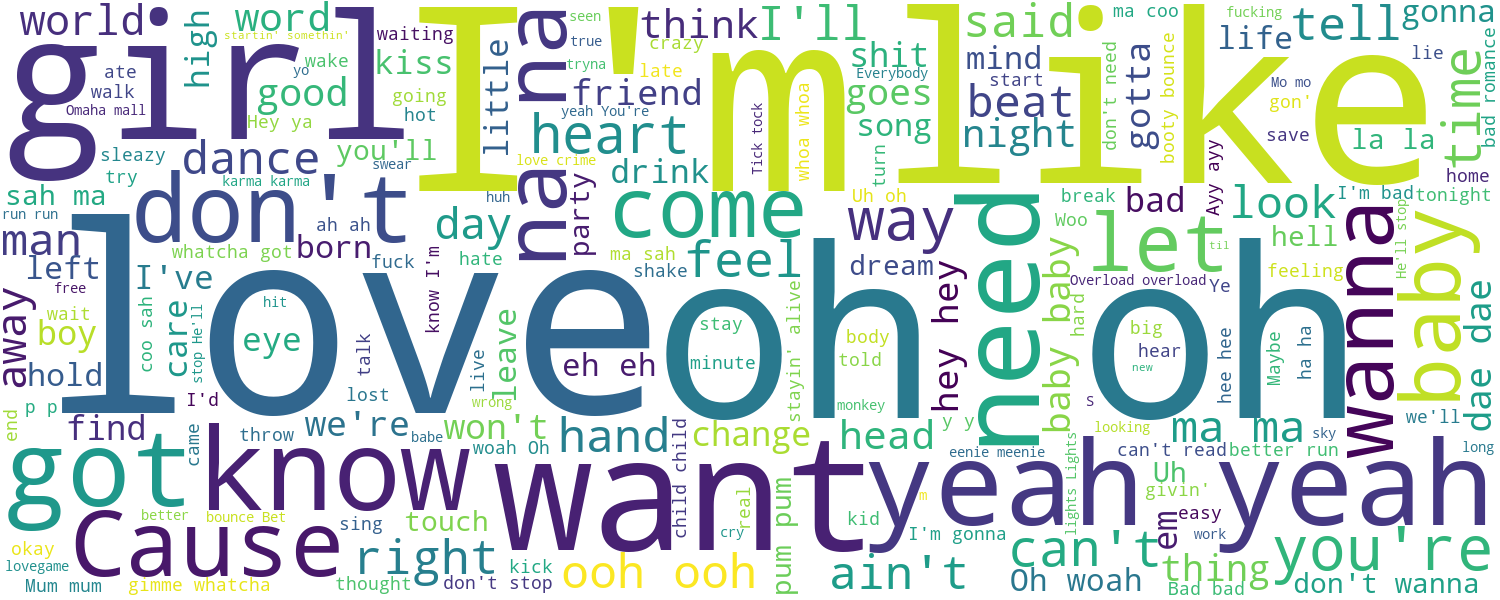

In [14]:
nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])
wc = WordCloud(background_color="white", width=1500, height=600, stopwords=spacy.lang.en.stop_words.STOP_WORDS)
wc.generate(" ".join(df[df["tag"] == "pop"].loc[:10000, "lyrics"])).to_image()

In [15]:
del wc
gc.collect()

1386

## Clustering songs

In [16]:
# Checking a sample vector
text = df.loc[1661, "lyrics"]
doc = nlp(text)
np.linalg.norm(doc.vector) # The vectors are not normalized

2.9270163

In [17]:
parts = {
    (1, 0, 1000000),
    (2, 1000000, 2000000),
    (3, 2000000, df.shape[0])
}

# Getting 300D vectors for each of the songs. Running on the entire english lyrics dataset would take more than the session time,
# so we do it in parts, saving results to disk
if not os.path.isfile("/kaggle/working/vectors.npy"):
    if not os.path.isfile("/kaggle/working/vectors.npz"):
        for part_name, start, end in parts:
            if not os.path.isfile(f"/kaggle/working/vectors_part{part_name}.npy"):
                # This can take 12h btw
                np.save(
                    f"/kaggle/working/vectors_part{part_name}.npy",
                    np.stack((nlp(text).vector for text in df.loc[start:end - 1, "lyrics"])) # -1 because loc includes end index
                )

        # Joining saved results
        vectors = np.empty(shape=(df.shape[0], 300), dtype='float64')
        for part_name, start, end in parts:
            temp_vectors = np.load(f"/kaggle/working/vectors_part{part_name}.npy", mmap_mode="r")
            vectors[start:end] = temp_vectors
        
        # have to save compressed(npz), otherwise we don't have enough persistent space
        np.savez_compressed("/kaggle/working/vectors.npz", vectors=vectors)
    else: 
        vectors = np.load("/kaggle/working/vectors.npz")["vectors"]
    
    for part_name, _, _ in parts:
        # Only delete everything when we don't need it anymore
        if os.path.isfile(f"/kaggle/working/vectors_part{part_name}.npy"):
            os.remove(f"/kaggle/working/vectors_part{part_name}.npy")
        
    # now that we have space we can save as npy (we need it as npy to use mmap_mode)
    np.save("/kaggle/working/vectors.npy", vectors)
    os.remove("/kaggle/working/vectors.npz")
    
    del vectors
    gc.collect()

In [18]:
X = np.load("/kaggle/working/vectors.npy", mmap_mode="c")

pipe = make_pipeline(Normalizer(copy=False), MiniBatchKMeans(n_clusters=6, random_state=0, batch_size=100000))
pipe.fit(X)
preds = pipe.predict(X)

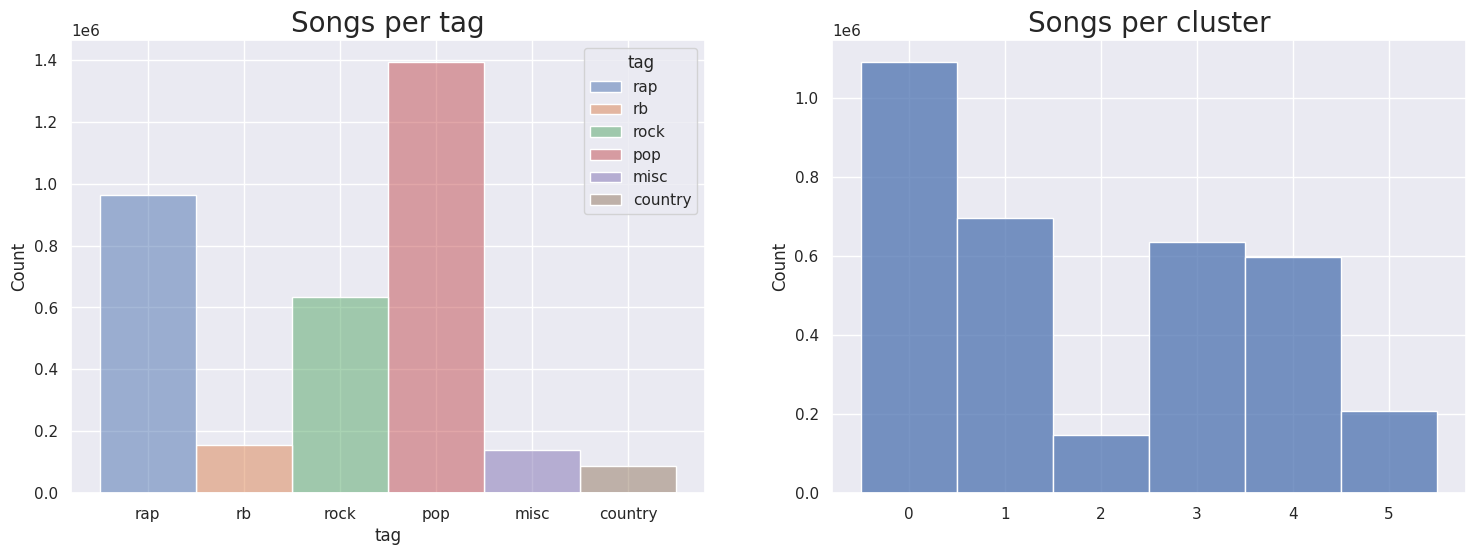

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi=100)
sns.histplot(x="tag", data=df, hue="tag", ax=ax1)
ax1.set_title("Songs per tag", fontsize=20)

sns.histplot(preds, bins=6, discrete=True, ax=ax2)
ax2.set_title("Songs per cluster", fontsize=20)
plt.show()

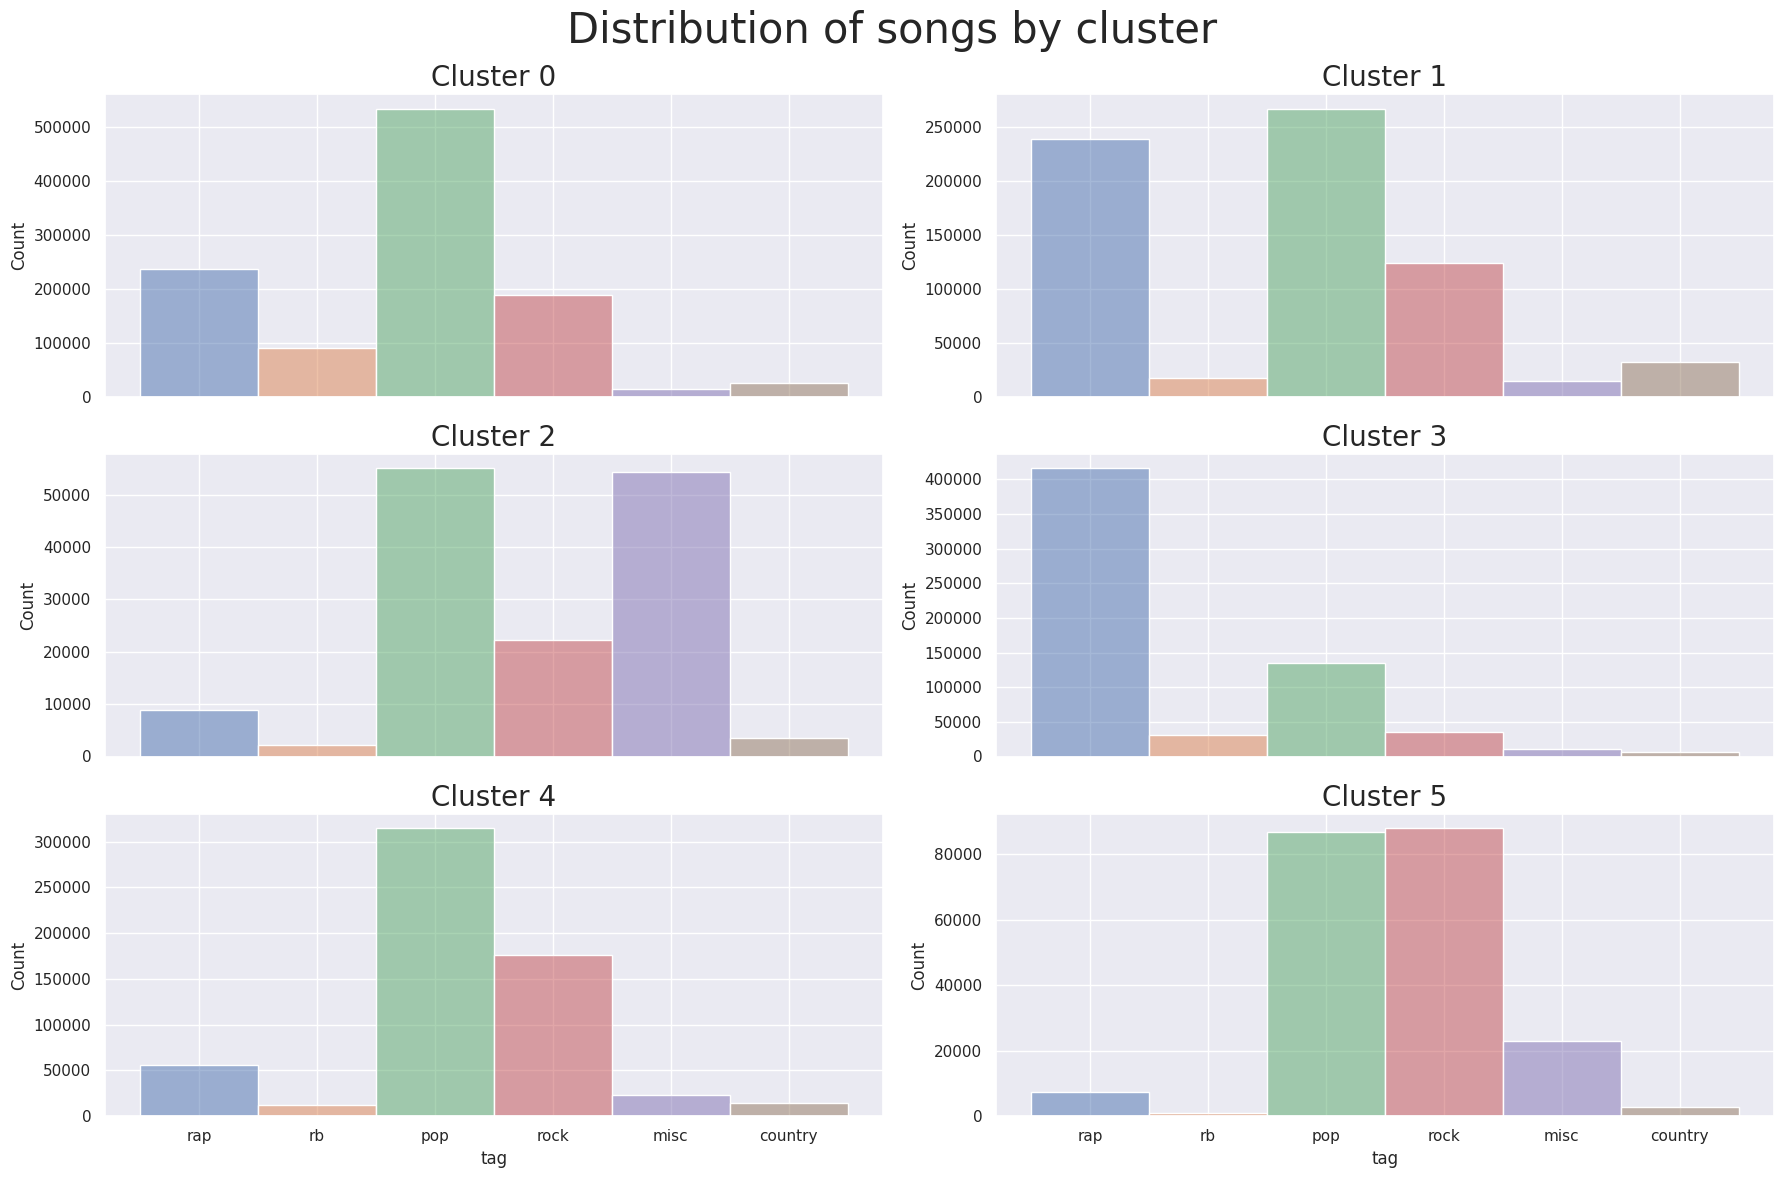

In [20]:
# Visualizing cluster elements
fig, axes = plt.subplots(3, 2, figsize=(18, 12), dpi=100, sharex=True)

cluster_num = 0
for row in range(3):
    for col in range(2):
        sns.histplot(df.loc[preds == cluster_num, "tag"], ax=axes[row][col])
        for patch, color in zip(axes[row][col].patches, sns.color_palette(n_colors=6).as_hex()):
            patch.set_facecolor((*to_rgb(color), 0.5))
        
        axes[row][col].set_title(f"Cluster {cluster_num}", fontsize=20)
        cluster_num += 1

fig.suptitle("Distribution of songs by cluster", fontsize=30)
fig.tight_layout()
plt.show()